In [1]:
"""
import things required
"""
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
"""
Helper functions to load data
"""
def load_mnist_dataset(dataset, path):
    """
    returns samples and lables specified by path and dataset params

    loop through each label and append image to X and label to y
    """
    labels = os.listdir(os.path.join(path, dataset))

    X = []
    y = []
    
    for label in labels:
        image_counter = 0
        for file in os.listdir(os.path.join(path, dataset, label)):
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    """
    returns train X, y and test X and y
    """
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)
    
    return X, y, X_test, y_test

In [3]:
"""
get train and test data 
scale data to be in range of -1 to 1 i.e. centered around 0
"""
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Scale features
X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

# print(X.min(), X.max())
# print(X.shape)

In [5]:
print(X.shape)
print(y.shape)

(60000, 28, 28)
(60000,)


In [6]:
"""
pixel size - 28 x 28 - 784 features
images are reshaped to be next to each other
"""
# Reshape to vectors
X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X.shape[1]

784

[0 1 2 3 4 5 6 7 8 9]


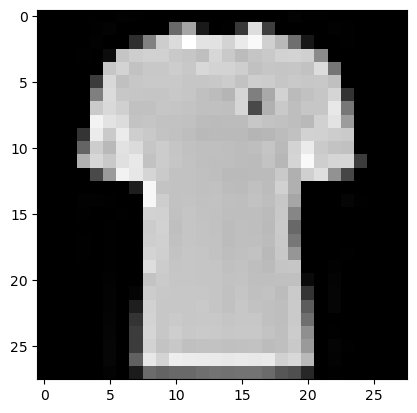

In [7]:
"""
shuffle the keys to remove biase that might be caused towards one label
"""
keys = np.array(range(X.shape[0]))
print(keys[:10])
np.random.shuffle(keys)
X = X[keys]
y = y[keys]
plt.imshow((X[4].reshape(28, 28)), cmap='gray')
plt.show()

In [8]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, 
                 weight_regularizer_l1=0, weight_regularizer_l2=0, 
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        """
        n_inputs represents the no of features
        n_neurons represents the no of neurons we want in this particular layer

        weights are inputs x no of neurons - helps avoid transpose operation in dot product
        weights range between -1 to +1 so tht they are close to each other and NN doesn't explode
        
        biases is set to zero initially and if we encounter error where the entore output of
        NN is zero we cqan intialize it to some value to avoid dead ANN
        
        rest four parameters referes to lambda that will be used for
        L1 and L2 regularization
        """
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
            self.weights
        
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
            self.biases
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [9]:
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        # input negative - gradient zero
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        self.inputs = inputs

        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [10]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        mean_loss = np.mean(sample_losses)
        return mean_loss
    
    def regularization_loss(self, layer):

        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        # account for zero values -log(0) = inf and then remove biasis caused by its intro
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            # y_true is in the form of [1, 0, 1, 1 ....]
            correct_confidences = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            # y_true is in the form of matric [[0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0]....]
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        negative_log_likelihood = - np.log(correct_confidences)

        return negative_log_likelihood
    
    def backward(self, dvalues, y_true):
        
        samples = len(dvalues)
        labels = len(dvalues[0])
        # convert to hot vector if not
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()   

    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [ ]:
class Optimizer_SGD:
    """
    SGD without momentum
    SDG with Momentum option - if specified else default 0
    """
    def __init__(self, learning_rate=1.0, decay=0, momentum=0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If we use momentum
        if self.momentum:

            # create momentum array if not present along with biases
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        # Update weights and biases using either vanilla or momentum update
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

In [12]:
"""
Features = 784
Samples = 60,000
class labels = 10 (0 - 9)

2 hidden layes - ReLU    - 128 neurons each
1 output layer - Softmax - 10 output neurons

Optimizer - SGD
learning rate decay - 0.01
l2 regularization - lambda - 5e-4 (0.0005)
"""

dense1 = Layer_Dense(X.shape[1], 128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(128, 128)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(128, 10)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay=0.01)

accuracies_sgd = []
losses_sgd = []
learning_rate = []

In [13]:
for epoch in range(1100):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    data_loss = loss_activation.forward(dense3.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + \
        loss_activation.loss.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)


    if not epoch % 10:
        accuracies_sgd.append(accuracy)
        losses_sgd.append(loss)
        learning_rate.append(optimizer.current_learning_rate)
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}'
             + f'Rr: {regularization_loss}')

    loss_activation.backward(loss_activation.output, y)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.096, loss: 2.308, lr: 1.0Rr: 0.005013977771864498
epoch: 10, acc: 0.215, loss: 1.837, lr: 0.9174311926605504Rr: 0.0052932212937370155
epoch: 20, acc: 0.136, loss: 2.335, lr: 0.8403361344537815Rr: 0.04673865016803641
epoch: 30, acc: 0.115, loss: 2.235, lr: 0.7751937984496123Rr: 0.0474798288857692
epoch: 40, acc: 0.264, loss: 1.982, lr: 0.7194244604316546Rr: 0.04845644284228443
epoch: 50, acc: 0.032, loss: 2.383, lr: 0.6711409395973155Rr: 0.054531087131002756
epoch: 60, acc: 0.191, loss: 2.169, lr: 0.628930817610063Rr: 0.058298930333085
epoch: 70, acc: 0.290, loss: 1.902, lr: 0.591715976331361Rr: 0.06091108234272053
epoch: 80, acc: 0.404, loss: 1.584, lr: 0.5586592178770949Rr: 0.06103500102755085
epoch: 90, acc: 0.284, loss: 1.997, lr: 0.5291005291005291Rr: 0.06156542051235255
epoch: 100, acc: 0.260, loss: 1.802, lr: 0.5025125628140703Rr: 0.06244491644395994
epoch: 110, acc: 0.296, loss: 1.776, lr: 0.47846889952153115Rr: 0.062347514228712556
epoch: 120, acc: 0.443, loss:

epoch: 990, acc: 0.845, loss: 0.480, lr: 0.09182736455463728Rr: 0.054659533139755974
epoch: 1000, acc: 0.845, loss: 0.479, lr: 0.09099181073703366Rr: 0.05458161863224329
epoch: 1010, acc: 0.845, loss: 0.479, lr: 0.09017132551848513Rr: 0.054504494436765694
epoch: 1020, acc: 0.845, loss: 0.478, lr: 0.08936550491510277Rr: 0.054428168792544265
epoch: 1030, acc: 0.846, loss: 0.478, lr: 0.08857395925597873Rr: 0.054352662348855975
epoch: 1040, acc: 0.846, loss: 0.477, lr: 0.08779631255487269Rr: 0.054278006220644305
epoch: 1050, acc: 0.846, loss: 0.477, lr: 0.08703220191470844Rr: 0.05420418669212498
epoch: 1060, acc: 0.846, loss: 0.476, lr: 0.08628127696289906Rr: 0.05413109160948577
epoch: 1070, acc: 0.846, loss: 0.476, lr: 0.0855431993156544Rr: 0.05405867467525899
epoch: 1080, acc: 0.847, loss: 0.475, lr: 0.08481764206955046Rr: 0.05398690000759705
epoch: 1090, acc: 0.847, loss: 0.474, lr: 0.08410428931875526Rr: 0.05391577071235945


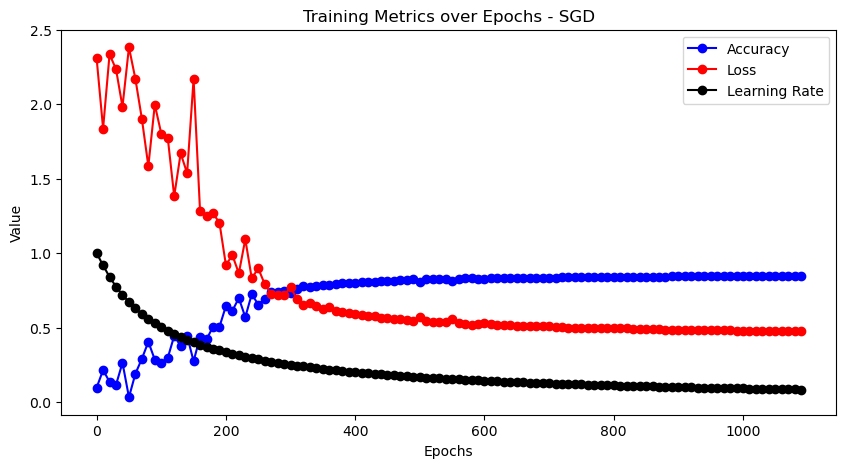

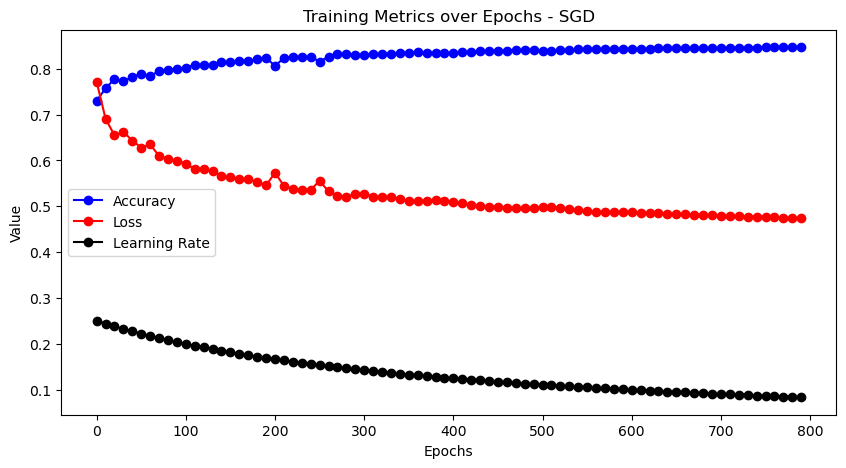

In [14]:
epochs = range(0, 1100, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_sgd, label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses_sgd, label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate, label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs - SGD')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

epochs = range(0, 800, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_sgd[30:], label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses_sgd[30:], label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate[30:], label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs - SGD')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

In [15]:
# Validate the model

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
data_loss = loss_activation.forward(dense3.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y_test)
print(f'validation - SGD, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation - SGD, acc: 0.833, loss: 0.474


In [20]:
"""
Features = 784
Samples = 60,000
class labels = 10 (0 - 9)

2 hidden layes - ReLU    - 128 neurons each
1 output layer - Softmax - 10 output neurons

Optimizer - SGD with momentum (0.5)
learning rate decay - 0.01
l2 regularization - lambda - 5e-4 (0.0005)
"""

dense1 = Layer_Dense(X.shape[1], 128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(128, 128)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(128, 10)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay=0.01, momentum=0.5)

accuracies_mom = []
losses_mom = []
learning_rate = []

In [21]:
for epoch in range(1100):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    data_loss = loss_activation.forward(dense3.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + \
        loss_activation.loss.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)


    if not epoch % 10:
        accuracies_mom.append(accuracy)
        losses_mom.append(loss)
        learning_rate.append(optimizer.current_learning_rate)
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}'
             + f'Rr: {regularization_loss}')

    loss_activation.backward(loss_activation.output, y)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.070, loss: 2.308, lr: 1.0Rr: 0.00503343727903207
epoch: 10, acc: 0.102, loss: 9.068, lr: 0.9174311926605504Rr: 0.007474826802391185
epoch: 20, acc: 0.158, loss: 2.516, lr: 0.8403361344537815Rr: 0.27192697559379725
epoch: 30, acc: 0.279, loss: 2.122, lr: 0.7751937984496123Rr: 0.26757800612310556
epoch: 40, acc: 0.272, loss: 2.356, lr: 0.7194244604316546Rr: 0.26561551479816753
epoch: 50, acc: 0.240, loss: 2.225, lr: 0.6711409395973155Rr: 0.2616486037013331
epoch: 60, acc: 0.230, loss: 4.213, lr: 0.628930817610063Rr: 0.2595395807597197
epoch: 70, acc: 0.423, loss: 2.184, lr: 0.591715976331361Rr: 0.40876334154444693
epoch: 80, acc: 0.402, loss: 1.914, lr: 0.5586592178770949Rr: 0.4016385205904229
epoch: 90, acc: 0.488, loss: 1.638, lr: 0.5291005291005291Rr: 0.39527351468614047
epoch: 100, acc: 0.502, loss: 1.463, lr: 0.5025125628140703Rr: 0.3878204130123266
epoch: 110, acc: 0.631, loss: 1.361, lr: 0.47846889952153115Rr: 0.3814228475238515
epoch: 120, acc: 0.647, loss: 1.227

epoch: 990, acc: 0.877, loss: 0.548, lr: 0.09182736455463728Rr: 0.2063370311657284
epoch: 1000, acc: 0.878, loss: 0.546, lr: 0.09099181073703366Rr: 0.20562971923802648
epoch: 1010, acc: 0.878, loss: 0.545, lr: 0.09017132551848513Rr: 0.20493095540384038
epoch: 1020, acc: 0.878, loss: 0.544, lr: 0.08936550491510277Rr: 0.2042408285638163
epoch: 1030, acc: 0.878, loss: 0.543, lr: 0.08857395925597873Rr: 0.20355937531311674
epoch: 1040, acc: 0.879, loss: 0.541, lr: 0.08779631255487269Rr: 0.2028862578301819
epoch: 1050, acc: 0.879, loss: 0.540, lr: 0.08703220191470844Rr: 0.20222128891233956
epoch: 1060, acc: 0.879, loss: 0.539, lr: 0.08628127696289906Rr: 0.2015643424047353
epoch: 1070, acc: 0.879, loss: 0.538, lr: 0.0855431993156544Rr: 0.20091534385054344
epoch: 1080, acc: 0.879, loss: 0.537, lr: 0.08481764206955046Rr: 0.20027405678769697
epoch: 1090, acc: 0.879, loss: 0.536, lr: 0.08410428931875526Rr: 0.1996403552875046


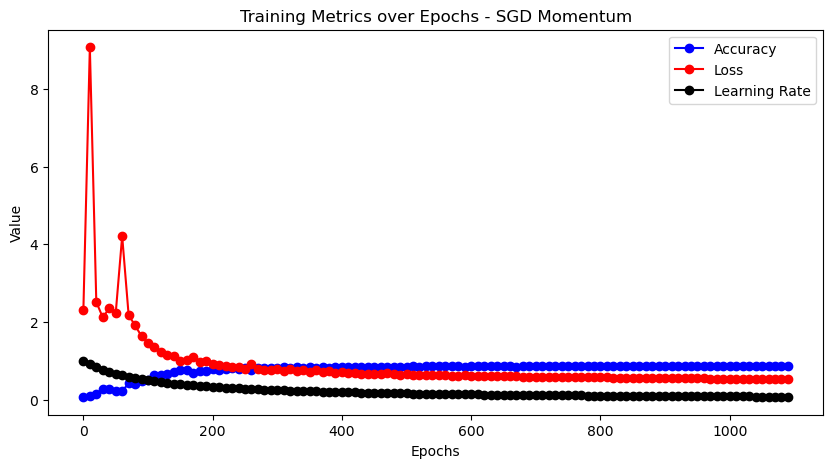

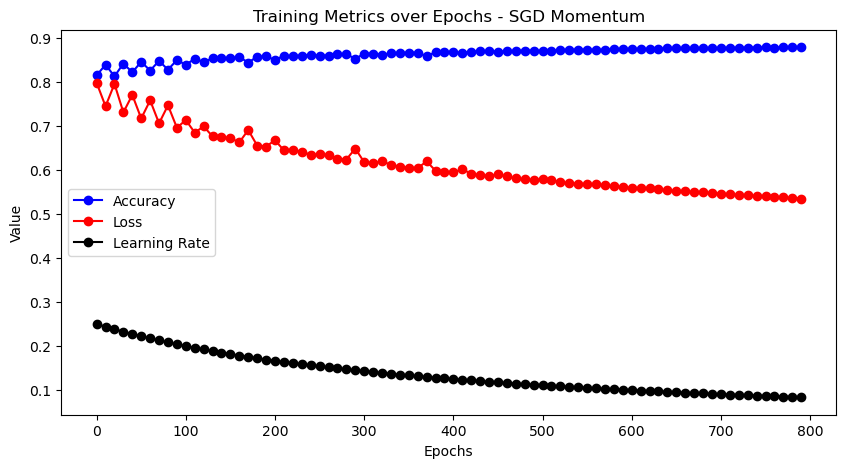

In [22]:
epochs = range(0, 1100, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_mom, label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses_mom, label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate, label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs - SGD Momentum')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

epochs = range(0, 800, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_mom[30:], label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses_mom[30:], label='Loss', marker='o', color='red')
plt.plot(epochs, learning_rate[30:], label='Learning Rate', marker='o', color='black')
plt.title('Training Metrics over Epochs - SGD Momentum')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

In [23]:
# Validate the model

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
data_loss = loss_activation.forward(dense3.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y_test)
print(f'validation - SGD Momentum, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation - SGD Momentum, acc: 0.859, loss: 0.535


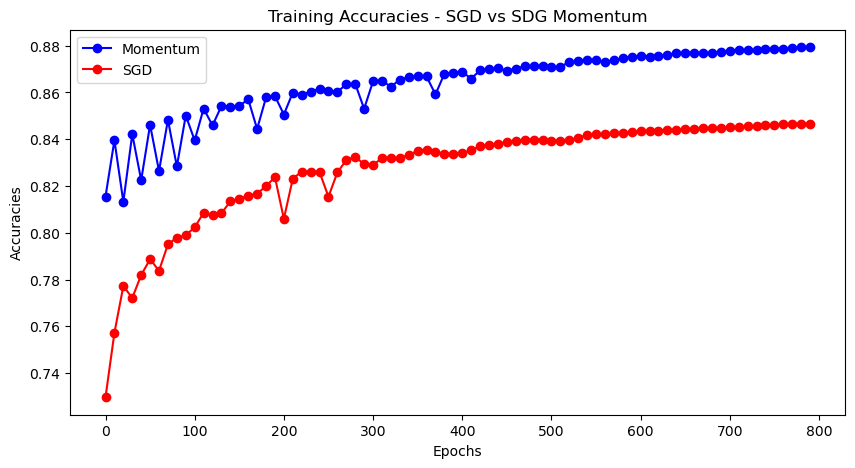

In [24]:
epochs = range(0, 800, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_mom[30:], label='Momentum', marker='o', color="blue")
plt.plot(epochs, accuracies_sgd[30:], label='SGD', marker='o', color='red')
plt.title('Training Accuracies - SGD vs SGD Momentum')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

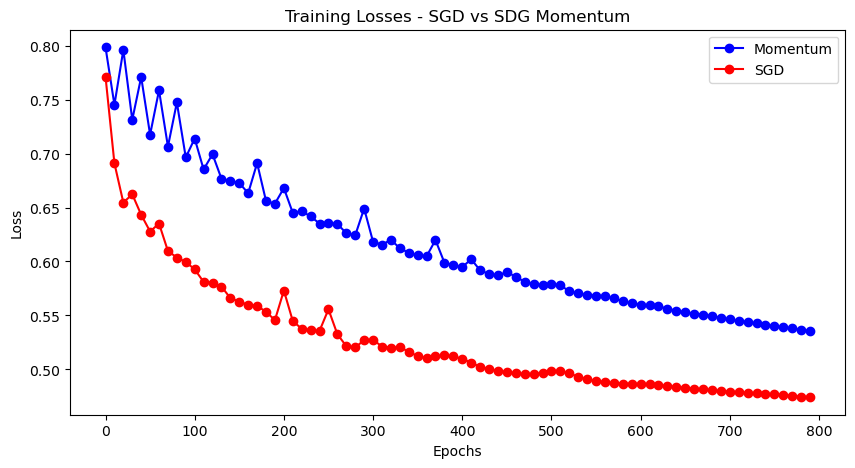

In [25]:
epochs = range(0, 800, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses_mom[30:], label='Momentum', marker='o', color="blue")
plt.plot(epochs, losses_sgd[30:], label='SGD', marker='o', color='red')
plt.title('Training Losses - SGD vs SGD Momentum')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

In [28]:
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def post_update_params(self):
        self.iterations += 1

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)


In [35]:
"""
Features = 784
Samples = 60,000
class labels = 10 (0 - 9)

2 hidden layes - ReLU    - 128 neurons each
1 output layer - Softmax - 10 output neurons

Optimizer - Adam
learning rate decay - 0.00001
l2 regularization - lambda - 5e-4 (0.0005)
"""

dense1 = Layer_Dense(X.shape[1], 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 10)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

accuracies_adam = []
losses_adam = []
learning_rate = []

In [36]:
for epoch in range(1100):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    data_loss = loss_activation.forward(dense3.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2) + \
        loss_activation.loss.regularization_loss(dense3)

    loss = data_loss + regularization_loss

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)


    if not epoch % 10:
        accuracies_adam.append(accuracy)
        losses_adam.append(loss)
        learning_rate.append(optimizer.current_learning_rate)
        print(f'epoch: {epoch}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}, ' + f'lr: {optimizer.current_learning_rate}'
             + f'Rr: {regularization_loss}')

    loss_activation.backward(loss_activation.output, y)
    dense3.backward(loss_activation.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.155, loss: 2.305, lr: 0.02Rr: 0.0025263644081304232
epoch: 10, acc: 0.530, loss: 1.104, lr: 0.019998200161985422Rr: 0.06838004892398145
epoch: 20, acc: 0.728, loss: 0.786, lr: 0.019996200721862846Rr: 0.10975816222691194
epoch: 30, acc: 0.795, loss: 0.651, lr: 0.019994201681512364Rr: 0.10756110198759783
epoch: 40, acc: 0.834, loss: 0.551, lr: 0.019992203040814085Rr: 0.08936902478611256
epoch: 50, acc: 0.848, loss: 0.482, lr: 0.01999020479964817Rr: 0.07264873067136424
epoch: 60, acc: 0.857, loss: 0.457, lr: 0.01998820695789484Rr: 0.06433640596218972
epoch: 70, acc: 0.860, loss: 0.441, lr: 0.01998620951543435Rr: 0.060406713232857845
epoch: 80, acc: 0.861, loss: 0.452, lr: 0.019984212472147003Rr: 0.06933477878578499
epoch: 90, acc: 0.870, loss: 0.422, lr: 0.019982215827913156Rr: 0.06770273390739527
epoch: 100, acc: 0.850, loss: 0.455, lr: 0.01998021958261321Rr: 0.058866257987493495
epoch: 110, acc: 0.868, loss: 0.419, lr: 0.01997822373612762Rr: 0.056924397360275915
epoch: 

epoch: 980, acc: 0.853, loss: 0.501, lr: 0.019806098297665855Rr: 0.10059461331434698
epoch: 990, acc: 0.873, loss: 0.455, lr: 0.019804137084236898Rr: 0.09837591282551299
epoch: 1000, acc: 0.879, loss: 0.426, lr: 0.019802176259170884Rr: 0.08613857902908013
epoch: 1010, acc: 0.883, loss: 0.407, lr: 0.019800215822352467Rr: 0.07451196992002639
epoch: 1020, acc: 0.873, loss: 0.417, lr: 0.019798255773666344Rr: 0.06664992638490679
epoch: 1030, acc: 0.876, loss: 0.411, lr: 0.019796296112997262Rr: 0.06198642504480136
epoch: 1040, acc: 0.770, loss: 0.726, lr: 0.019794336840230013Rr: 0.06342130020544352
epoch: 1050, acc: 0.821, loss: 0.581, lr: 0.01979237795524943Rr: 0.0838898004585479
epoch: 1060, acc: 0.854, loss: 0.495, lr: 0.019790419457940408Rr: 0.08612107286023024
epoch: 1070, acc: 0.867, loss: 0.454, lr: 0.01978846134818787Rr: 0.07744064556622776
epoch: 1080, acc: 0.874, loss: 0.426, lr: 0.01978650362587679Rr: 0.06961412965378659
epoch: 1090, acc: 0.879, loss: 0.408, lr: 0.0197845462908921

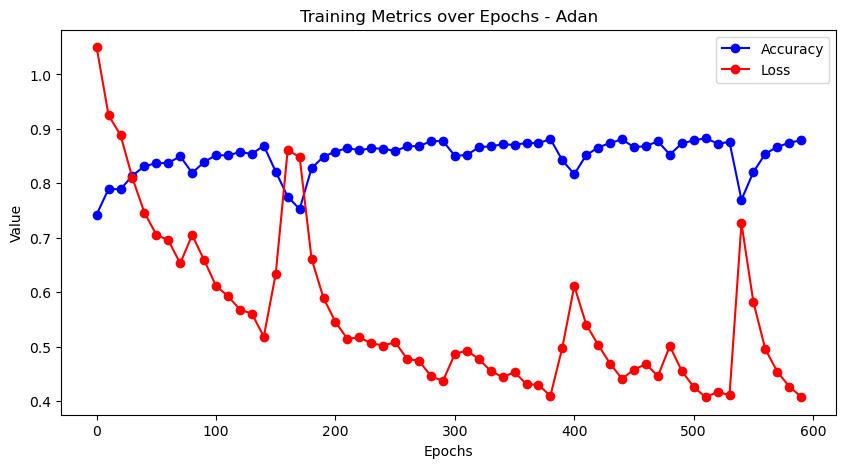

In [44]:
epochs = range(0, 600, 10) 
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies_adam[50:], label='Accuracy', marker='o', color="blue")
plt.plot(epochs, losses_adam[50:], label='Loss', marker='o', color='red')
plt.title('Training Metrics over Epochs - Adan')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_metrics_plot.png')
plt.show()

In [38]:
# Validate the model

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
data_loss = loss_activation.forward(dense3.output, y_test)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y_test)
print(f'validation - Adam, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation - Adam, acc: 0.841, loss: 0.477
